In [14]:
library(data.table)
library(mixOmics)
library(raster)
library(pracma)
library(ggpubr)

In [ ]:
#Schizophrenia EWAS results for sites previously identified as associated with tobacco smoking
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")

In [ ]:
sample_id_phase1 <- read.csv("~/Documents/data/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_phase2 <- read.csv("~/Documents/data/E-GEOD-84727.sdrf.txt",sep = "\t")

In [ ]:
phase1 <- fread("~/Documents/data/GSE80417_normalizedBetas.csv", header = T)
phase2 <- fread("~/Documents/data/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(phase1$V1,phase2$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)


phase1 <- subset(phase1, V1 %in% common_probes)
phase2 <- subset(phase2, V1 %in% common_probes)

In [1]:
probe_set=9

In [ ]:
if(probe_set==7){
    train_residual <- read.csv("./schizo_test_network.csv",header = T,stringsAsFactors = F)
    test_residual <- read.csv("./schizo_train_network.csv",header = T,stringsAsFactors = F)
    print(dim(train_residual))
    print(dim(test_residual))
}

In [ ]:
if(probe_set==8){
    train_network <- read.csv("./train_network_features.csv",header = T,stringsAsFactors = F)
    print(dim(train_network))
    head(train_network)
    test_network <- read.csv("./test_network_features.csv",header = T,stringsAsFactors = F)
    print(dim(test_network))
    head(test_network)  
}

In [24]:
if(probe_set==9){
    train_residual <- read.csv("./schizo_test_network.csv",header = T,stringsAsFactors = F)
    train_residual$CaseControl <- NULL
    test_residual <- read.csv("./schizo_train_network.csv",header = T,stringsAsFactors = F)
    test_residual$CaseControl <- NULL
    train_network <- read.csv("./train_network_features.csv",header = T,stringsAsFactors = F)
    test_network <- read.csv("./test_network_features.csv",header = T,stringsAsFactors = F)
  
}

In [25]:
head(train_residual)
head(train_network)
train <- merge(train_residual,train_network,by="individuals")
test <- merge(test_residual,test_network,by="individuals")
train$status <- as.factor(train$CaseControl)
test$status <- as.factor(test$CaseControl)
train$individuals <- NULL
test$individuals <- NULL
train$CaseControl <- NULL
test$CaseControl <- NULL



,individuals,cg07902789_cg12639453,cg00175403_cg12639453,cg04087271_cg12639453,cg22607339_cg12639453,cg13450265_cg12639453,cg24323958_cg12639453,cg10807101_cg12639453,cg12132508_cg12639453,cg16532282_cg12639453,⋯,cg20659941_cg26136497,cg27206367_cg26136497,cg07537739_cg07703790,cg15177613_cg18530645,cg15035382_cg12138330,cg17840843_cg23693200,cg14709901_cg20096897,cg02238362_cg11460509,cg02238362_cg24114772,cg17852224_cg12301347
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100973330060_R01C01,-0.04286508,-0.14599854,-0.155853696,-0.15273723,-0.034290575,-0.03649846,-0.0469902221,-0.1771321,-0.09265846,⋯,-0.03268953,-0.03295512,-0.12039290,-0.11069068,-0.10946607,-0.0297723863,0.15161127,-0.07903638,-0.056668790,-0.08472236
2,100973330060_R03C02,-0.12056131,-0.19443734,-0.112810058,-0.16190037,-0.098025665,-0.11535240,-0.1403056072,-0.1944608,-0.14817127,⋯,-0.03001069,-0.03766304,-0.11524192,0.01577290,-0.08764821,-0.0191978499,0.20709125,-0.01140725,-0.051920207,0.05743063
3,100973330060_R05C02,0.01464566,-0.08877316,-0.003527859,-0.09668545,0.006896746,0.02917324,0.0113115835,-0.0881682,-0.05639047,⋯,-0.05707255,-0.05763213,-0.10710971,-0.09987433,-0.05690603,-0.0022502216,0.19374998,-0.07896289,-0.050684694,-0.02709119
4,100973330060_R06C01,0.01389552,-0.05896536,-0.084120638,-0.11306962,-0.037944688,0.02195657,0.0001238355,-0.1220823,-0.03722048,⋯,-0.04314034,-0.04800528,-0.07985556,-0.12224288,-0.07907047,-0.0109385724,0.16928755,-0.11720098,-0.126987393,0.10665966
5,100973330060_R06C02,-0.04413512,-0.16957885,-0.114078651,-0.10976063,-0.058955436,-0.02733400,-0.0296359335,-0.1430461,-0.11311835,⋯,-0.06792879,-0.05325082,-0.11422252,0.13233390,-0.07888386,0.0073118521,-0.00743229,-0.08426754,-0.092816092,0.01965058
6,100973330068_R01C01,-0.07074898,-0.11104210,-0.097482777,-0.13259747,-0.072123097,-0.03198939,-0.0426436760,-0.1540519,-0.06344561,⋯,-0.09278889,-0.09538473,-0.11542985,-0.12857324,-0.09985410,-0.0002925175,0.11901931,-0.07915745,0.007835593,0.10781196


,individuals,CaseControl,diameters,edge_densities,mean_betweeness,mean_edge_betweenness,mean_authrity_score,mean_degree,cg00175403_degree,cg00201175_degree,⋯,cg25385940_nodeAuScore,cg25520356_nodeAuScore,cg25619440_nodeAuScore,cg26076750_nodeAuScore,cg26091304_nodeAuScore,cg26706520_nodeAuScore,cg27044861_nodeAuScore,cg27408171_nodeAuScore,cg27490568_nodeAuScore,cg27529346_nodeAuScore
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100973330060_R01C01,0,3,0.03061224,1.0204082,3.611111,0.03547168,1.469388,0,4,⋯,0.000000e+00,0.2477519,7.495931e-17,0.000000e+00,7.495931e-17,8.995117e-17,7.495931e-17,0.1918227,0.000000e+00,0.0000000
2,100973330060_R03C02,0,3,0.02666667,0.7647059,3.117647,0.03555422,1.333333,0,5,⋯,0.000000e+00,0.2124738,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.2841243,0.000000e+00,0.0000000
3,100973330060_R05C02,0,4,0.03401361,1.9387755,5.125000,0.05033382,1.632653,0,5,⋯,0.000000e+00,0.2505989,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.000000e+00,0.5561236
4,100973330060_R06C01,0,4,0.02655486,0.8888889,3.315789,0.03434131,1.407407,0,4,⋯,2.478715e-17,0.0000000,7.214945e-17,0.000000e+00,2.719870e-17,2.619164e-17,0.000000e+00,0.8544309,0.000000e+00,0.0000000
5,100973330060_R06C02,0,5,0.02688486,2.9152542,6.891304,0.07606017,1.559322,0,4,⋯,0.000000e+00,0.0000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.821343e-17,0.5487763,0.000000e+00,0.0000000
6,100973330068_R01C01,0,4,0.02557545,1.8550725,4.816667,0.03411358,1.739130,0,5,⋯,1.725672e-16,0.2722382,0.000000e+00,5.392726e-17,1.078545e-16,4.314181e-17,0.000000e+00,0.0000000,1.402109e-16,0.5217763


In [ ]:
if(probe_set==6){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv")
    phase1 <- subset(phase1, V1 %in% top_variable_probes$V1)
    phase2 <- subset(phase2, V1 %in% top_variable_probes$V1)
    phase1$V1 <- strcat(phase1$V1,"__")
    phase2$V1 <- strcat(phase2$V1,"__")
    train_network <- read.csv("./train_network_features.csv",header = T,stringsAsFactors = F)
    test_network <- read.csv("./test_network_features.csv",header = T,stringsAsFactors = F)

}

In [ ]:
if(probe_set==5){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv")
    phase1 <- subset(phase1, V1 %in% top_variable_probes$V1)
    phase2 <- subset(phase2, V1 %in% top_variable_probes$V1)
    train_residual <- read.csv("./schizo_train_network.csv",header = T,stringsAsFactors = F)
    test_residual <- read.csv("./schizo_test_network.csv",header = T,stringsAsFactors = F)
}

In [ ]:
if(probe_set==4){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv",stringsAsFactors = F)
    #top_variable_probes <- top_variable_probes[1:500,]
    probe_loc <- read.csv("~/Documents/research/mccs_cancer_cohort/ALL_CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",header = T,stringsAsFactors = F,sep = ",")
    probe_loc <- probe_loc[order(probe_loc$chr, probe_loc$pos),]
    probe_loc <- probe_loc[!duplicated(probe_loc$CG),]
    probe_loc <- probe_loc[!duplicated(probe_loc$cluster_id),]
    
    phase1 <- subset(phase1, V1 %in% unique(c(probe_loc$CG,top_variable_probes$V1)))
    phase2 <- subset(phase2, V1 %in% unique(c(probe_loc$CG,top_variable_probes$V1)))
    
    
    
}

In [ ]:
if(probe_set==3){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv")
    phase1 <- subset(phase1, V1 %in% top_variable_probes$V1)
    phase2 <- subset(phase2, V1 %in% top_variable_probes$V1)
}

In [ ]:
if(probe_set == 2){
    table_s3_hannon_et_al_2016 <- read.csv("~/Documents/data/schizo_data_table_s3.csv",header = T)
    phase1 <- subset(phase1, V1 %in% table_s3_hannon_et_al_2016$probe_id)
    phase2 <- subset(phase2, V1 %in% table_s3_hannon_et_al_2016$probe_id)
}


In [ ]:
if(probe_set==1 | probe_set==7 | probe_set==8  ){
    probe_loc <- read.csv("~/Documents/research/mccs_cancer_cohort/CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",header = T,stringsAsFactors = F,sep = ",")
    probe_loc <- probe_loc[order(probe_loc$chr, probe_loc$pos),]
    probe_loc <- probe_loc[!duplicated(probe_loc$CG),]

    average_corsiv_methylation <- function(DF){

        temp_clinical <- DF[ , !grepl( "cg[0-9]" , names( DF ) ) ]
        probe_data <-DF[ , grepl( "cg[0-9]" , names( DF ) )]

        avg_prob_df <- data.frame(matrix(ncol = 0, nrow = dim(probe_data)[1]))

        for(probe_cluster_id in unique(probe_loc$cluster_id)){
            #print(probe_cluster_id)
            #probe_cluster_id <- "single14"
            probs_temp <- probe_loc[probe_loc$cluster_id==probe_cluster_id,]$CG
            if(length(intersect(colnames(probe_data),probs_temp)) > 0){
                data_prob_cluster <- probe_data[intersect(colnames(probe_data),probs_temp)]
                avg_prob_df[[probs_temp[1]]] <- apply(data_prob_cluster, 1,mean)
            }
        }
        return(cbind(temp_clinical,avg_prob_df))
    }
    
    phase1 <- subset(phase1, V1 %in% probe_loc$CG)
    phase2 <- subset(phase2, V1 %in% probe_loc$CG)
}


In [ ]:
colnames_phase1 <- phase1$V1
phase1$V1 <- NULL
phase1_t <- data.frame(t(phase1))
colnames(phase1_t) <- colnames_phase1
phase1_t$sample.id <- rownames(phase1_t)
rownames(phase1_t) <- NULL

In [ ]:
colnames_phase2 <- phase2$V1
phase2$V1 <- NULL
phase2_t <- data.frame(t(phase2))
colnames(phase2_t) <- colnames_phase2
phase2_t$sample.id <- rownames(phase2_t)
rownames(phase2_t) <- NULL

In [ ]:
#phase 2 data to train and phase 1 data to test
test <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
train <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))


In [ ]:
if(probe_set==1 | probe_set==7 | probe_set==8){
    train <- average_corsiv_methylation(train)
    test <- average_corsiv_methylation(test)
    }

In [ ]:
if(probe_set==5){
    train <- merge(train,train_residual,by.x="id",by.y="individuals")
    test <- merge(test,test_residual,by.x="id",by.y="individuals")
    train$CaseControl <- NULL
    test$CaseControl <- NULL
    
}

In [ ]:
if(probe_set==6){
    train <- merge(train,train_network,by.x="id",by.y="individuals")
    test <- merge(test,test_network,by.x="id",by.y="individuals")
    train$CaseControl <- NULL
    test$CaseControl <- NULL
    
}

In [ ]:
dim(train)
head(train)
dim(test)
head(test)

In [ ]:
if(probe_set==8){
    
    train <- merge(train,train_network,by.x="id",by.y="individuals")
    test <- merge(test,test_network,by.x="id",by.y="individuals")
    train$CaseControl <- NULL
    test$CaseControl <- NULL
}

In [ ]:
if(probe_set==7){
    
    train <- merge(train,train_residual,by.x="id",by.y="individuals")
    test <- merge(test,test_residual,by.x="id",by.y="individuals")
    train$CaseControl <- NULL
    test$CaseControl <- NULL
}

In [ ]:
#build on phase 2
train$id <- NULL
train$sample_title <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

test$id  <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))

#build on phase 1
train$id <- NULL
train$gender <- NULL
train$age <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

test$id  <- NULL
test$sample_title <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))


In [26]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 2,keepX=c(50,50))

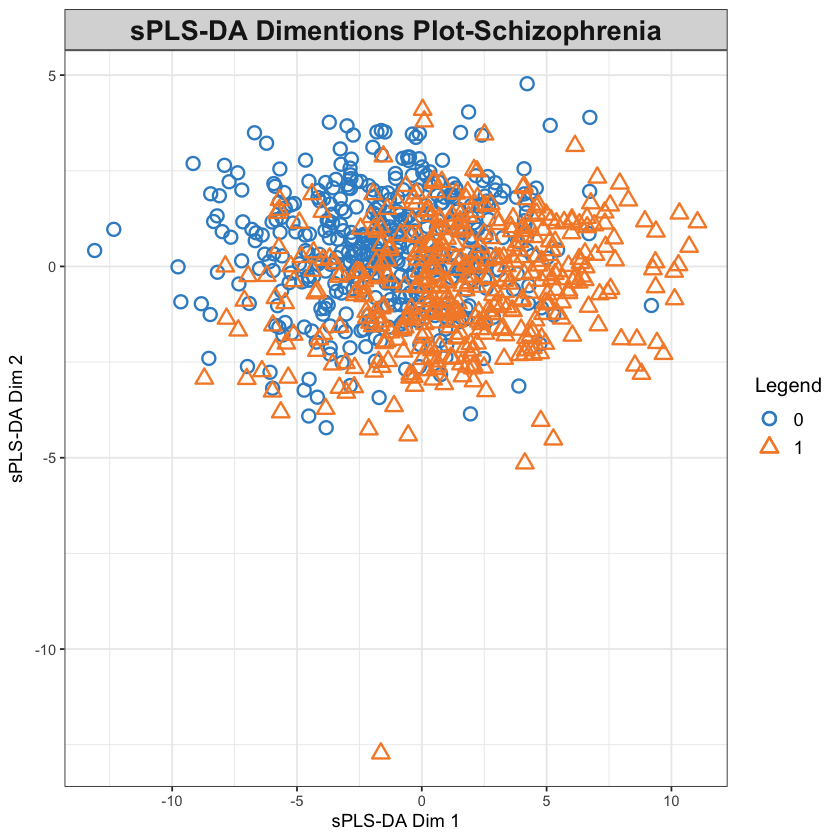

In [27]:
v <- plotIndiv(splsda_output_beta, ind.names = FALSE, legend=TRUE,
               ellipse = FALSE, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"),
               X.label = 'sPLS-DA Dim 1', Y.label = 'sPLS-DA Dim 2',graphics.off=T)

[1] 2.506212
[1] -1.361125


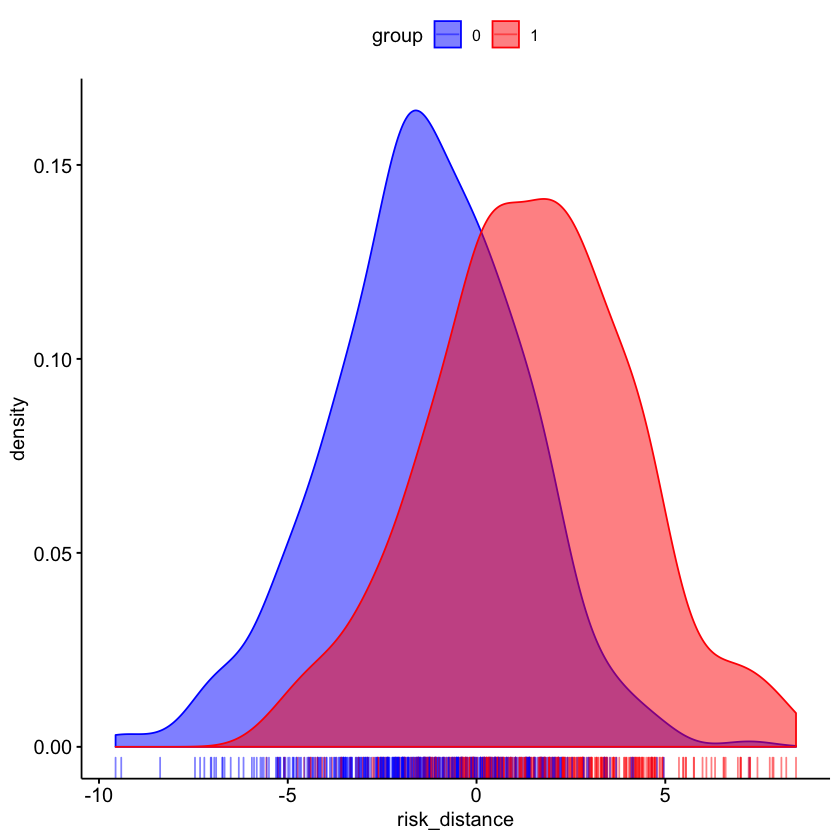

In [28]:
plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
risk_distance <- function(cancer_sample){
    X <- as.numeric(cancer_sample[1])
    Y <- as.numeric(cancer_sample[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) + deg2rad(45)))# - for MBCN + for BC
}
plsdaDF$risk_distance <- 1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]
cutoff <- 2*sd(plot.data[plot.data$group==0,]$risk_distance)
ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))
stdev_controls <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_controls <- mean(plot.data[plot.data$group==0,]$risk_distance)
print(stdev_controls)
print(mean_controls)

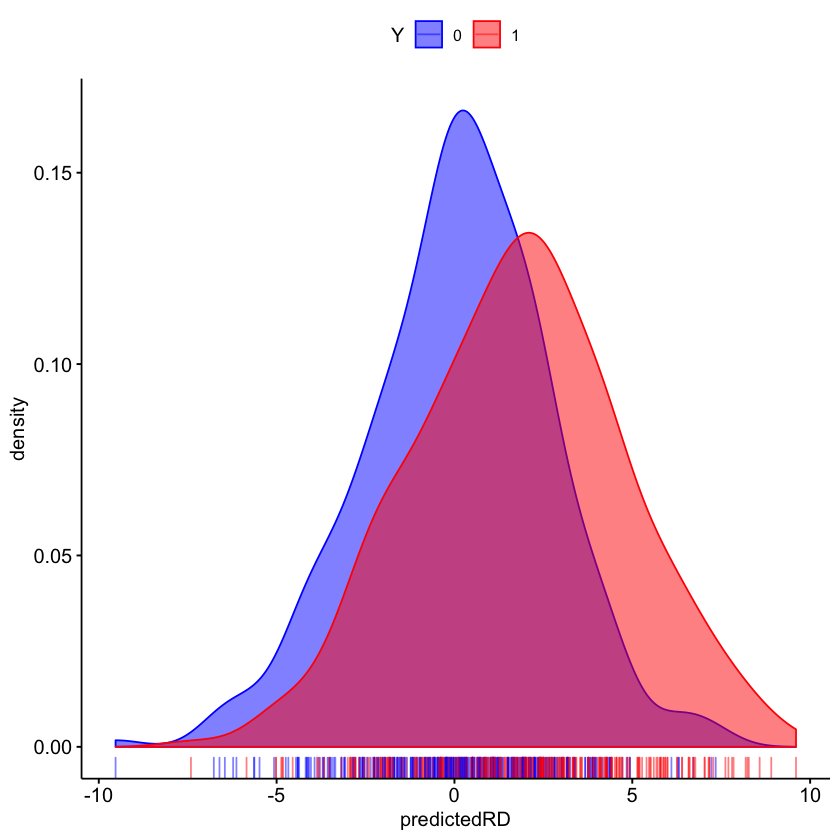

In [29]:
########### PREDICTION ######
##########################################################################
Y <- test$status
test$status <- NULL

test.predict <- predict(splsda_output_beta, test)

predicted_RD <- data.frame(1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

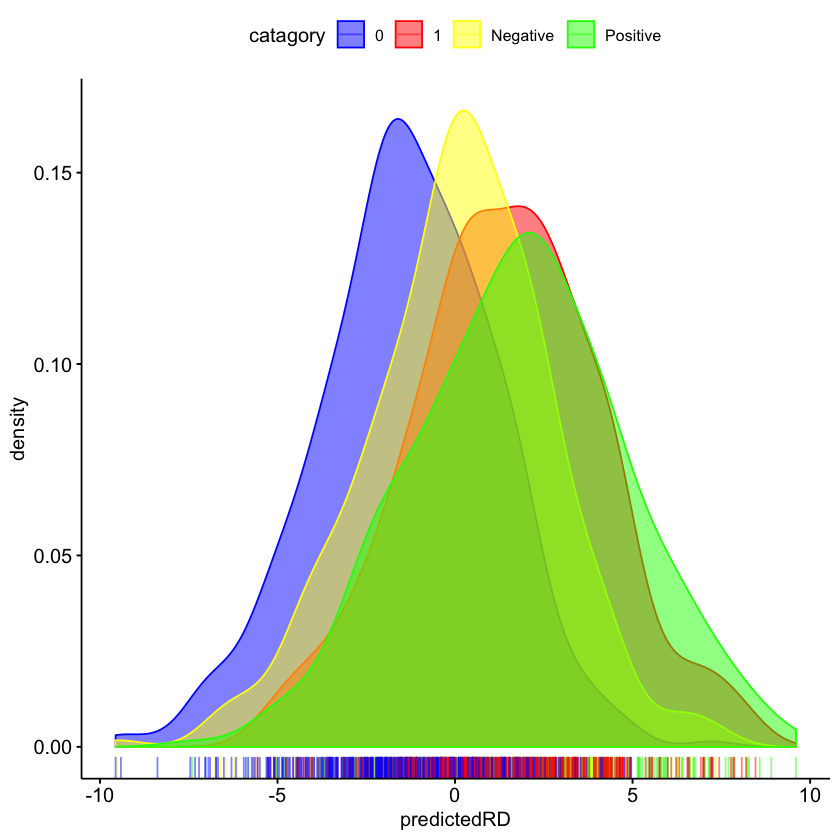

In [30]:
predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","yellow","green"))

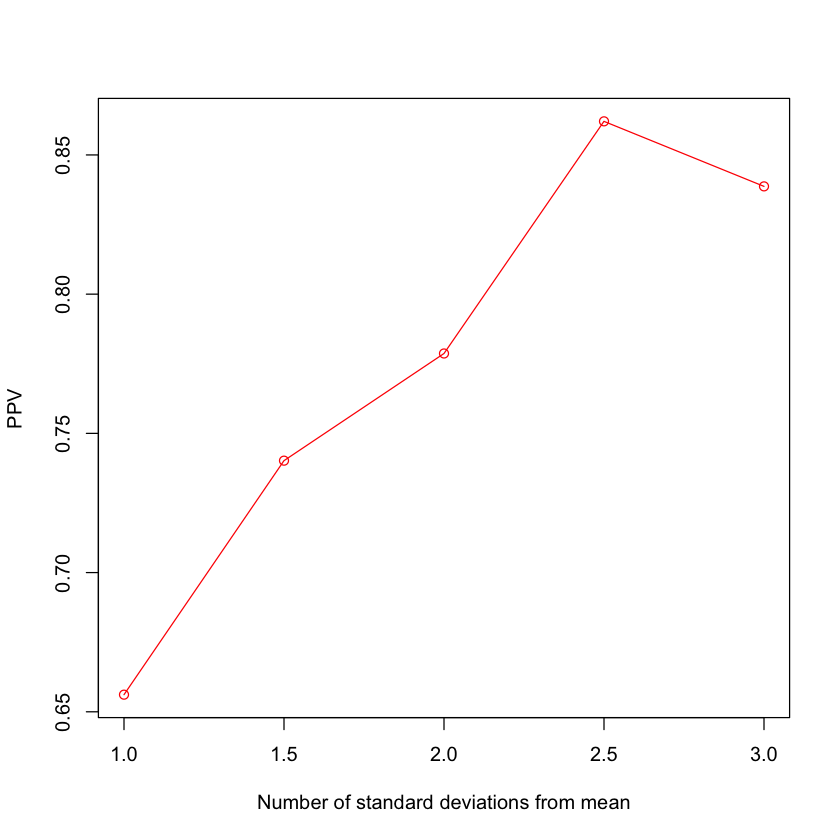

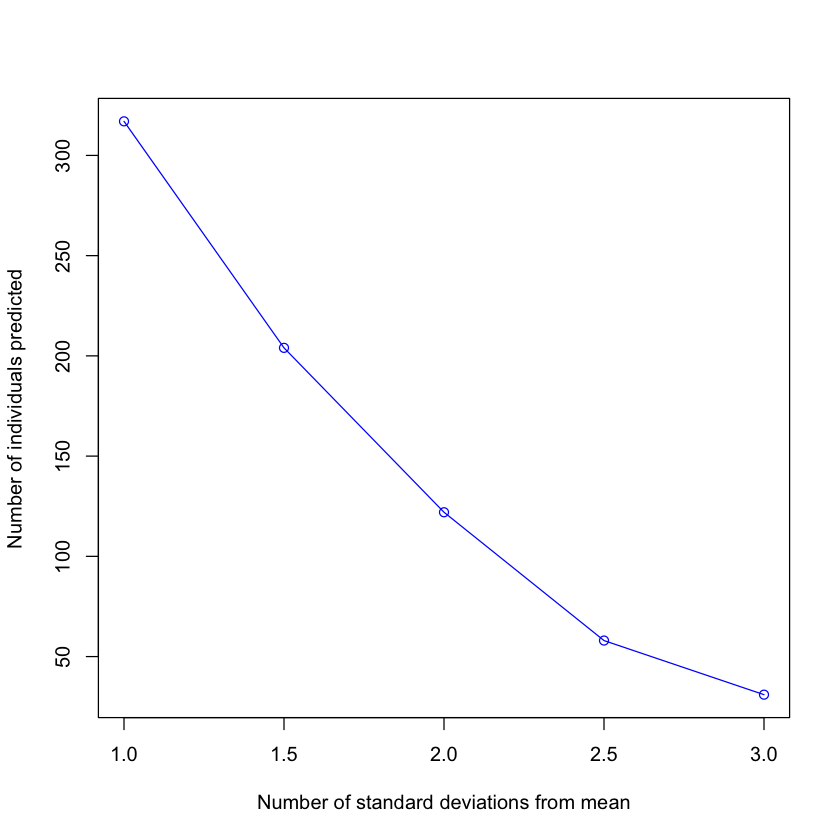

In [31]:
#################################################
PPV <-c()
num_of_predicted_ind <- c()
#stdev <- sd(plot.data[plot.data$catagory==0,]$risk_distance)#increase n
#mean_PRD <- mean(plot.data[plot.data$catagory==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev_controls
    cutoff <- mean_controls + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}

plot(x=seq(1,3,0.5),y=PPV,type="o",col="red",xlab="Number of standard deviations from mean")
plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")

In [32]:
num_of_predicted_ind

[1] 317 204 122  58  31

In [33]:
PPV

[1] 0.6561514 0.7401961 0.7786885 0.8620690 0.8387097

In [ ]:
varComp1 <- selectVar(splsda_output_beta,comp = 1)
varComp2 <- selectVar(splsda_output_beta,comp = 2)

selected_C1 <- data.frame(varComp1$value)
selected_C2 <- data.frame(varComp2$value)

selected_C1$probe_id <- row.names(selected_C1)
selected_C2$probe_id <- row.names(selected_C2)

In [ ]:
selected_C1[order(abs(selected_C1$value.var),decreasing=T),]
selected_C2[order(abs(selected_C2$value.var),decreasing=T),]

In [ ]:
variables_in_model_2 <- c(varComp1$name,varComp2$name)
length(variables_in_model_2)
variables_in_model_2

In [ ]:
write.csv(data.frame(variables_in_model_2),file="test.csv")

In [ ]:
variables_in_model_1 <- c(varComp1$name,varComp2$name)
length(variables_in_model_1)
variables_in_model_1

In [ ]:
length(intersect(variables_in_model_1,variables_in_model_2))

In [ ]:
hm450k_probe_gene_table <- read.csv("./HM450k_probe_gene_table.csv")

In [ ]:
temp <- subset(hm450k_probe_gene_table, probe_id %in% variables_in_model)
write.csv(temp,file="test.csv")

In [ ]:
temp

In [ ]:
library(devtools)
install_bitbucket("ibi_group/disgenet2r")

In [ ]:
library(disgenet2r)

In [ ]:
data1 <- gene2disease( gene = "SNED1",
                       database = "ALL")

In [ ]:
plot( data1,
      class = "Network",
      prop = 20)

In [ ]:
i